# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [34]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


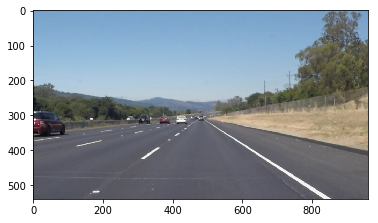

In [35]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)

plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Parameters

In [36]:
# Parameters
Find_Best_Parameters = True # Set to true to test different techniques. Set to False to see the final result
Draw_Lines_Method = 3 # values: 1 to 4: 
# 1. Average slope and Y-Intercepts of lines. 
# 2. Best fit of the points forming the lines (each line contribute by 2 points). Not done. 3 is better
# 3. Best fit of points along the lines. Each line contribute with at least 2 points. It could be more depending on the length of the line
# 4. Segments Best fit: Only consider the lines with y lies in the lower half of the region of interest (if not consider all the lines)

MaxY= image.shape[0]
MaxX= image.shape[1]
ignore_mask_color = 255
#(150,530),(450, 310), (490, 310), (850,530)
RegionLowerY = 530
RegionUpperY = 310
RegionLowerY_X1 = 150
RegionLowerY_X2 = 850
RegionUpperY_X1 = 450
RegionUpperY_X2 = 490
vertices = np.array([[(RegionLowerY_X1,RegionLowerY),(RegionUpperY_X1, RegionUpperY), (RegionUpperY_X2, RegionUpperY), (RegionLowerY_X2,RegionLowerY)]], dtype=np.int32)

gaussian_kernel_sizes = [3,5,7,9,11]
canny_thresholds = [[50+(i*10), 150+(i*30)] for i in range(6)]
rhos = [1, 2, 3] # 2
thetasDegrees = [(i+1) for i in range(13)]
thetas = [i*np.pi/180 for i in thetasDegrees]

threshold = 50 # minimum number of votes (intersections in Hough grid cell) #
min_line_len = 10 #minimum number of pixels making up a line #
max_line_gap = 40 # maximum gap in pixels between connectable line segmentsrho2 = 1 # 2 # 1 # distance resolution in pixels of the Hough grid

if Find_Best_Parameters==True:
    gaussian_kernel_size = 3 # default
    canny_threshold=canny_thresholds[0] # (50,150)
    canny_low_threshold = canny_threshold[0]
    canny_high_threshold = canny_threshold[1]
    rho = 1 # default
    theta = 1*np.pi/180 # default
else:
    gaussian_kernel_size = gaussian_kernel_size=gaussian_kernel_sizes[0]
    canny_threshold=canny_thresholds[0]
    canny_low_threshold = canny_threshold[0]
    canny_high_threshold = canny_threshold[1]
    rho=rhos[0]
    theta = thetas[0]
print ("gaussian_kernel_size: ", gaussian_kernel_size, "\ncanny_low_threshold: ", canny_low_threshold, "\ncanny_high_threshold: ", canny_high_threshold, "\nrho: ", rho, "\ntheta: ", theta *180/np.pi)
print ("Vertices: (", RegionLowerY_X1,RegionLowerY, "),(", RegionUpperY_X1, RegionUpperY, "),(", RegionUpperY_X2, RegionUpperY, "),(", RegionLowerY_X2,RegionLowerY, ")")

gaussian_kernel_size:  3 
canny_low_threshold:  50 
canny_high_threshold:  150 
rho:  1 
theta:  1.0
Vertices: ( 150 530 ),( 450 310 ),( 490 310 ),( 850 530 )


In [37]:
# For testing to check proper settings
print ("vertices: ", vertices)
print ("gaussian_kernel_sizes: ", gaussian_kernel_size, " From: ", gaussian_kernel_sizes)
for canny_threshold in canny_thresholds:
    canny_low = canny_threshold[0]
    canny_high = canny_threshold[1]
print ("canny_thresholds: ", canny_low, canny_high, " From: ", canny_thresholds)
print ("rhos: ", rho, " From: ", rhos)
print ("thetasDegrees: ", thetasDegrees)
print ("thetas: ", "Deg: ", theta*180/np.pi, " Rad: ", theta," From: ", thetas)

vertices:  [[[150 530]
  [450 310]
  [490 310]
  [850 530]]]
gaussian_kernel_sizes:  3  From:  [3, 5, 7, 9, 11]
canny_thresholds:  100 300  From:  [[50, 150], [60, 180], [70, 210], [80, 240], [90, 270], [100, 300]]
rhos:  1  From:  [1, 2, 3]
thetasDegrees:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
thetas:  Deg:  1.0  Rad:  0.017453292519943295  From:  [0.017453292519943295, 0.03490658503988659, 0.05235987755982988, 0.06981317007977318, 0.08726646259971647, 0.10471975511965977, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295, 0.19198621771937624, 0.20943951023931953, 0.22689280275926285]


## Colors definition

In [38]:
BLUE = [0,0,255]
YELLOW = [255,255,0]
PURPLE = [128,0,128]
GREEN = [0,255,0]
RED = [255, 0, 0]

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtCoaddWeightedlor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [39]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def Xof(m,b,Y):
    # Y = mX+b -> X = (Y-b)/m
    return (int((Y-b)/m))
MIN_SLOP = 0.2


def best_fit (img, x, y):
    # calculate polynomial
    if len(x) > 1:
        z = np.polyfit(x, y, 1)
    #    f = np.poly1d(z)
        slop = z[0]
        y_intercept = z[1]
        # calculate new x's and y's
    #    x_new = np.linspace(x[0], x[-1], 50)
    #    y_new = f(x_new)

    #    plt.plot(x,y,'o', x_new, y_new)
    #    plt.xlim([x[0]-1, x[-1] + 1 ])
    #    plt.show()
        cv2.line(img, (Xof(slop,y_intercept,RegionUpperY+20), RegionUpperY+20), (Xof(slop,y_intercept,MaxY), MaxY), RED, 5)
        cv2.line(img, (Xof(slop,y_intercept,RegionUpperY+20), RegionUpperY+20), (Xof(slop,y_intercept,MaxY), MaxY), RED, 5)
        

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    if Draw_Lines_Method==1:
        draw_lines_average(img, lines, color=[255, 0, 0], thickness=2)
    elif Draw_Lines_Method==2:
        draw_lines_bestfit_endpoint(img, lines, color=[255, 0, 0], thickness=2)
    elif Draw_Lines_Method==3:
        draw_lines_bestfit_weighted_length(img, lines, color=[255, 0, 0], thickness=2)
    elif Draw_Lines_bestfit_lower_region==4:
        draw_lines_bestfit_lower_region(img, lines, color=[255, 0, 0], thickness=2)
    else:
        print("Error: No draw line method is specified")

def draw_lines_average(img, lines, color=[255, 0, 0], thickness=2):

    NumLinesP=0
    NumLinesN=0
    slopAccP=0.0
    y_interceptAccP=0.0
    slopAccN=0.0
    y_interceptAccN=0.0
    for line in lines:
        x1,y1,x2,y2 = line[0]
        x_diff = x2 - x1
        if (abs(x_diff) > 0.0001):  # Ignore lines paralle to the Y-axes
            slop = (y2-y1)/(x2-x1)
            y_intercept = y2 - slop*x2
            # Prepare 2- Average of slops and Y-intercepts in YELLOW: Generate 2 lines: Slop is the average of +ve and -ve slopes
            if (slop > MIN_SLOP):
                slopAccP += slop
                y_interceptAccP += y_intercept
                NumLinesP += 1
            elif(slop < -MIN_SLOP):
                slopAccN += slop
                y_interceptAccN += y_intercept
                NumLinesN += 1
    if (NumLinesP>0):
        slop = slopAccP / NumLinesP
        y_intercept = y_interceptAccP / NumLinesP
        cv2.line(img, (Xof(slop,y_intercept,RegionUpperY), RegionUpperY), (Xof(slop,y_intercept,MaxY), MaxY), RED, 5)
    if (NumLinesN>0):
        slop = slopAccN / NumLinesN
        y_intercept = y_interceptAccN / NumLinesN
        cv2.line(img, (Xof(slop,y_intercept,RegionUpperY), RegionUpperY), (Xof(slop,y_intercept,MaxY), MaxY), RED, 5)

def draw_lines_bestfit_endpoint(img, lines, color=[255, 0, 0], thickness=2):

    x_pos = []
    y_pos = []
    x_neg = []
    y_neg = []
    if isinstance(lines,np.ndarray):
        for line in lines:
            x1,y1,x2,y2 = line[0]
            x_diff = x2 - x1
            if (abs(x_diff) > 0.0001):  # Ignore lines paralle to the Y-axes
                slop = (y2-y1)/(x2-x1)
#                if((slop>=0.55 and slop<=0.70) or (slop<=-0.65 and  slop >=-0.77)):
                if((slop>=0.3 and slop<=1) or (slop<=-0.3 and  slop >=-1)):
                    if slop > 0.0:
                        x_pos.append(x1)
                        y_pos.append(y1)
                        x_pos.append(x2)
                        y_pos.append(y2)
                    else:
                        x_neg.append(x1)
                        y_neg.append(y1)
                        x_neg.append(x2)
                        y_neg.append(y2)

        best_fit(img, x_pos, y_pos)
        best_fit(img, x_neg, y_neg)

def draw_lines_bestfit_weighted_length(img, lines, color=[255, 0, 0], thickness=2):
    minlen = 500.0
    maxlen = 0.0
    step = 5         # for each line, considered it as many as (line length / step)
    
    length = 0
    x_pos = []
    y_pos = []
    x_neg = []
    y_neg = []
    if isinstance(lines,np.ndarray):
        for line in lines:
            x1,y1,x2,y2 = line[0]
            x_diff = x2 - x1
            if (abs(x_diff) > 0.0001):  # Ignore lines paralle to the Y-axes
                slop = (y2-y1)/(x2-x1)
#                if((slop>=0.55 and slop<=0.70) or (slop<=-0.65 and  slop >=-0.77)):
                if((slop>=0.3 and slop<=1) or (slop<=-0.3 and  slop >=-1)):
                    if slop > 0.0:
                        length = np.sqrt(np.square(x2-x1)+np.square(y2-y1))
                        if length > maxlen:
                            maxlen = length
                        if length < minlen:
                            minlen = length
                        for s in range(1, int(length), step):
#                        print (slop, x1, y1, x2, y2, length)
                            x_pos.append(x1)
                            y_pos.append(y1)
                            x_pos.append(x2)
                            y_pos.append(y2)
                    else:
                        length = np.sqrt(np.square(x2-x1)+np.square(y2-y1))
#                        print (slop, x1, y1, x2, y2, length)
                        if length > maxlen:
                            maxlen = length
                        if length < minlen:
                            minlen = length
                        for s in range(1, int(length), step):
                            x_neg.append(x1)
                            y_neg.append(y1)
                            x_neg.append(x2)
                            y_neg.append(y2)

        best_fit(img, x_pos, y_pos)
        best_fit(img, x_neg, y_neg)

def draw_lines_bestfit_lower_region(img, lines, color=[255, 0, 0], thickness=2):

    x_pos_lowy = []
    y_pos_lowy = []
    x_neg_lowy = []
    y_neg_lowy = []
    x_pos = []
    y_pos = []
    x_neg = []
    y_neg = []
    if isinstance(lines,np.ndarray):
        for line in lines:
            x1,y1,x2,y2 = line[0]
            x_diff = x2 - x1
            if (abs(x_diff) > 0.0001):  # Ignore lines paralle to the Y-axes
                slop = (y2-y1)/(x2-x1)
#                if((slop>=0.55 and slop<=0.70) or (slop<=-0.65 and  slop >=-0.77)):
                if((slop>=0.3 and slop<=1) or (slop<=-0.3 and  slop >=-1)):
                    if slop > 0.0:
                        x_pos.append(x1)
                        y_pos.append(y1)
                        x_pos.append(x2)
                        y_pos.append(y2)
                        if (y1>=RegionUpperY or y1>=RegionUpperY):
                            x_pos_lowy.append(x1)
                            y_pos_lowy.append(y1)
                            x_pos_lowy.append(x2)
                            y_pos_lowy.append(y2)
                    else:
                        x_neg.append(x1)
                        y_neg.append(y1)
                        x_neg.append(x2)
                        y_neg.append(y2)
                        if (y1>=RegionUpperY or y1>=RegionUpperY):
                            x_neg_lowy.append(x1)
                            y_neg_lowy.append(y1)
                            x_neg_lowy.append(x2)
                            y_neg_lowy.append(y2)

        if len(x_pos_lowy>0):
            best_fit(img, x_pos_lowy, y_pos_lowy)
        else:
            best_fit(img, x_pos, y_pos)
        if len(x_neg_lowy>0):
            best_fit(img, x_neg_lowy, y_neg_lowy)
        else:
            best_fit(img, x_neg, y_neg)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
#    for x1,y1,x2,y2 in lines[0]:
#        print (x1,y1,x2,y2)
#    draw_solid_lines(line_img, lines)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=3., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
    

In [40]:
def show(imgs):
    images_per_line = len(imgs)

    fig=plt.figure()
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, images_per_line, i+1)
        plt.imshow(img, cmap='gray')

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [41]:
# Prepare for reading, displaying and saving the images
import os
import PIL

# display settings
plt.rcParams["figure.figsize"] = (20,6)   # change matplotout parameters to allow for many images on the same line (original and laned). This is important for debuging

# set input and output directories, also create an output directory if not existing
testdir="test_images/"
testoutputdir="test_images_output/"
if (os.path.exists(testoutputdir)):
    pass
else:
    os.mkdir(testoutputdir)

# get two lists of images in a dictionary. One is a numpy array to perform all cv2 processing the second is a pillow image for save the resulting image
list_im = os.listdir(testdir)
print (list_im)
#pilImages = [ PIL.Image.open(testdir+imagefilename) for imagefilename in list_im ]
#imgs = [ mpimg.pil_to_array(pilImage) for pilImage in pilImages ]
imgs = [ mpimg.imread(testdir+imagefilename) for imagefilename in list_im ]


['solidWhiteCurve.jpg', 'solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg']


gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0


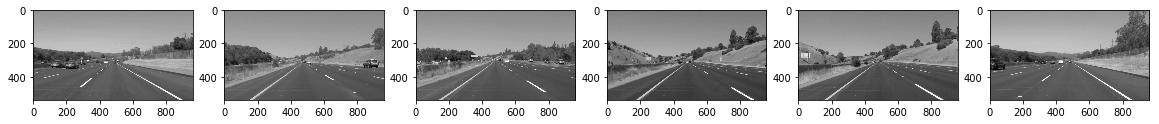

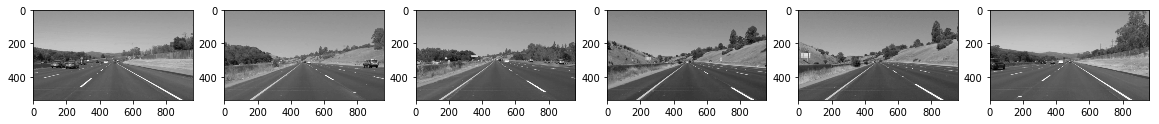

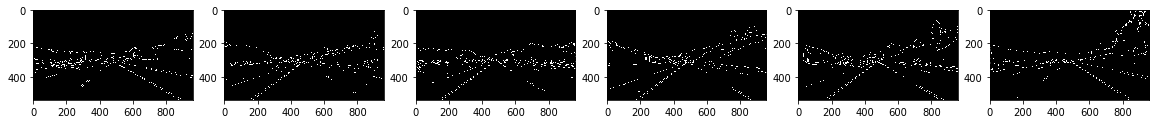

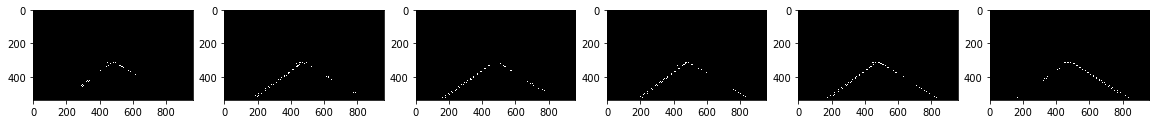

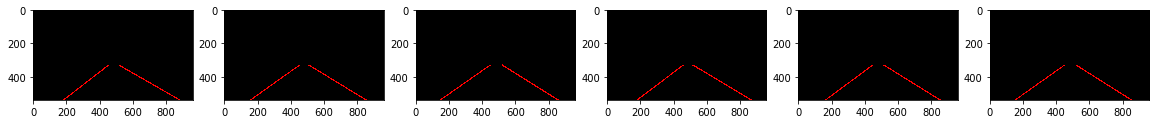

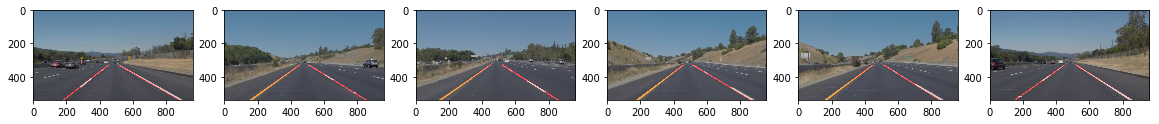

In [42]:
# main function to generate the output and intermediate images
gray_imgs = [ grayscale(img) for img in imgs ]
show(gray_imgs)
gaussian_imgs = [ gaussian_blur(gray_img, gaussian_kernel_size) for gray_img in gray_imgs ]
show(gaussian_imgs)
canny_edge_images = [ canny(gaussian_img, canny_low_threshold, canny_high_threshold) for gaussian_img in gaussian_imgs ]
show(canny_edge_images)
masks = [ region_of_interest(canny_edge_image, vertices) for canny_edge_image in canny_edge_images ]
show(masks)
houghs = [hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap) for mask in masks]
show(houghs)
weighted_imgs = [weighted_img(hough, initial_img) for (initial_img, hough) in zip(imgs, houghs)]
print ("gaussian_kernel_size: ", gaussian_kernel_size, " canny_low_threshold: ", canny_low_threshold, " canny_high_threshold: ", canny_high_threshold, " rho: ", rho, " theta: ", theta *180/np.pi)
show(weighted_imgs)

gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  2.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  3.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  4.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  5.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  6.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  7.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  8.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  th

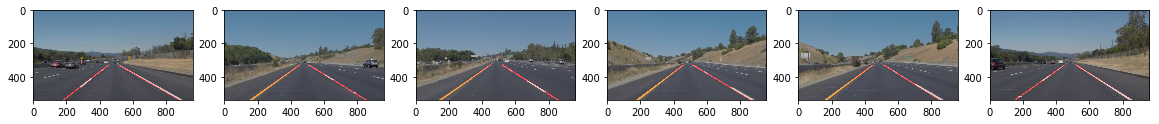

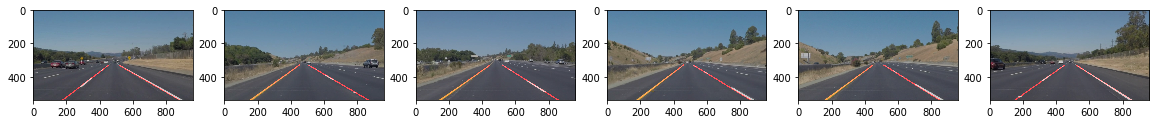

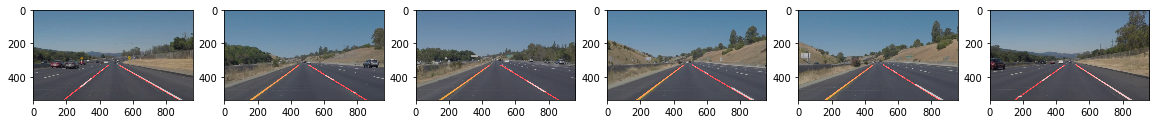

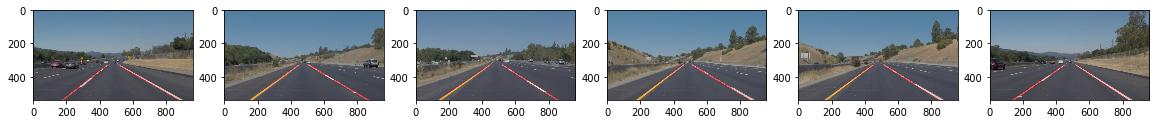

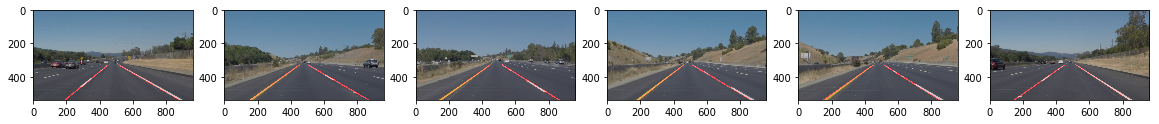

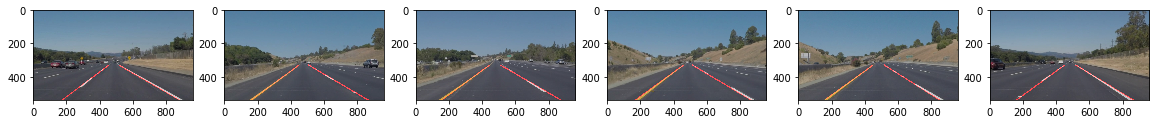

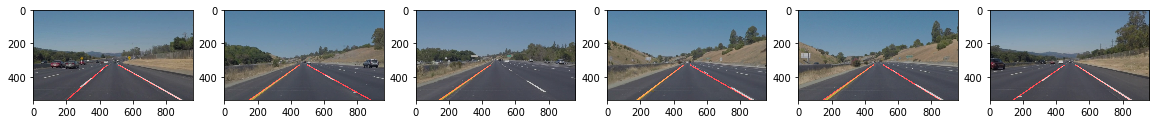

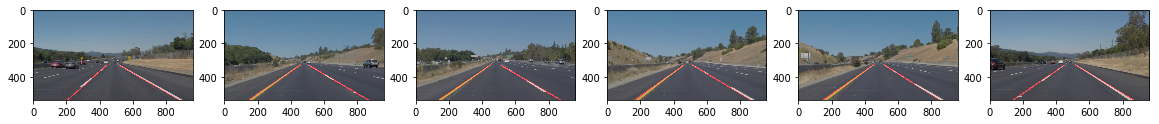

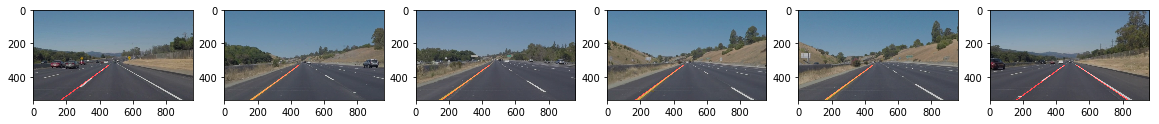

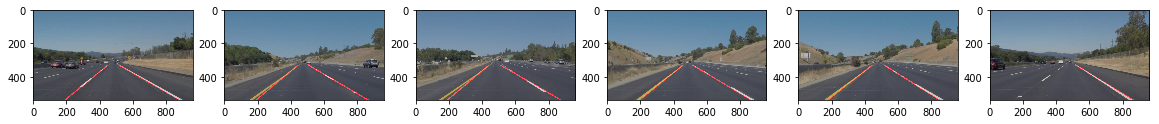

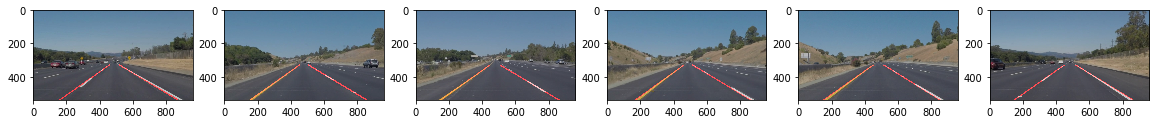

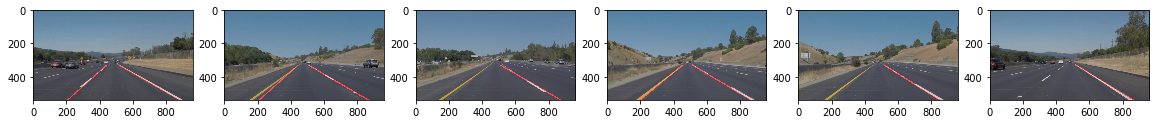

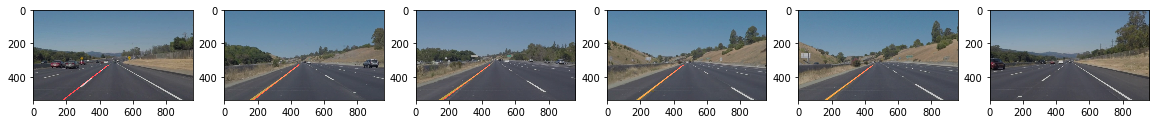

In [43]:
# main function to get the best theta
# result shows 10 degress. Modify the default as such
# started wit:
#   gaussian_kernel_size = 5 # default
#   canny_low_threshold = 50 # default
#   canny_high_threshold = 150 # default
#   rho = 1 # default

if Find_Best_Parameters == True:
    print ("gaussian_kernel_size: ", gaussian_kernel_size, " canny_low_threshold: ", canny_low_threshold, " canny_high_threshold: ", canny_high_threshold, " rho: ", rho, " theta: ", theta *180/np.pi)
    gray_imgs = [ grayscale(img) for img in imgs ]
    gaussian_imgs = [ gaussian_blur(gray_img, gaussian_kernel_size) for gray_img in gray_imgs ]
    canny_edge_images = [ canny(gaussian_img, canny_low_threshold, canny_high_threshold) for gaussian_img in gaussian_imgs ]
    masks = [ region_of_interest(canny_edge_image, vertices) for canny_edge_image in canny_edge_images ]
    for theta in thetas:
        houghs = [hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap) for mask in masks]
        weighted_imgs = [weighted_img(hough, initial_img) for (initial_img, hough) in zip(imgs, houghs)]
        images_per_line = len(weighted_imgs)
        fig=plt.figure()
        for i, img in enumerate(weighted_imgs):
            ax = plt.subplot(1, images_per_line, i+1)
            plt.title = 'Hello'
            plt.imshow(img, cmap='gray')
        print ("gaussian_kernel_size: ", gaussian_kernel_size, " canny_low_threshold: ", canny_low_threshold, " canny_high_threshold: ", canny_high_threshold, " rho: ", rho, " theta: ", theta *180/np.pi)
    

In [44]:
#Conclusion: theta of 0 is the best. 
if Find_Best_Parameters == True:
    theta=thetas[0]
    print (theta *180/np.pi)

1.0


gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  2  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  3  theta:  1.0


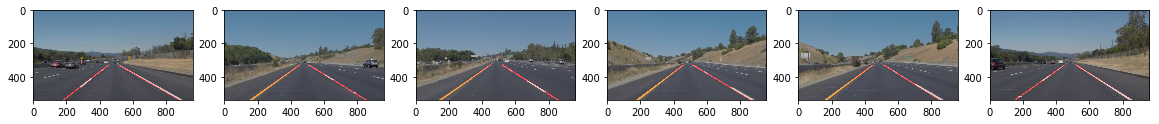

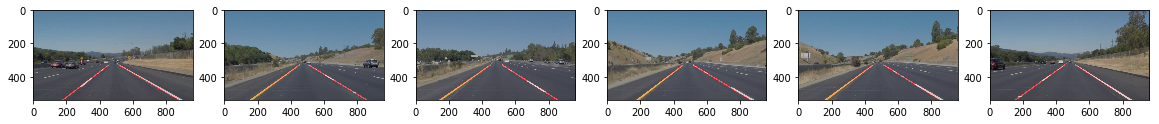

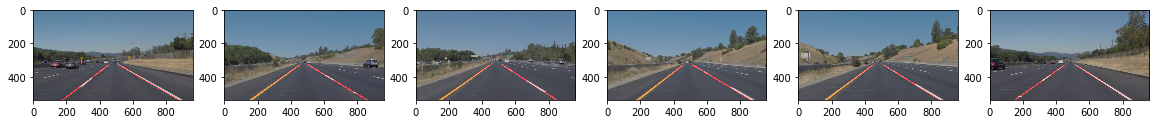

In [45]:
# main function to get the best rho
# result shows 10 degress. Modify the default as such
# started wit:
#   gaussian_kernel_size = 5 # default
#   canny_low_threshold = 50 # default
#   canny_high_threshold = 150 # default
#   rho = 1 # default

if Find_Best_Parameters == True:
    gray_imgs = [ grayscale(img) for img in imgs ]
    gaussian_imgs = [ gaussian_blur(gray_img, gaussian_kernel_size) for gray_img in gray_imgs ]
    canny_edge_images = [ canny(gaussian_img, canny_low_threshold, canny_high_threshold) for gaussian_img in gaussian_imgs ]
    masks = [ region_of_interest(canny_edge_image, vertices) for canny_edge_image in canny_edge_images ]
    for rho in rhos:
        houghs = [hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap) for mask in masks]
        weighted_imgs = [weighted_img(hough, initial_img) for (initial_img, hough) in zip(imgs, houghs)]
        images_per_line = len(weighted_imgs)
        fig=plt.figure()
        for i, img in enumerate(weighted_imgs):
            ax = plt.subplot(1, images_per_line, i+1)
            plt.title = 'Hello'
            plt.imshow(img, cmap='gray')
        print ("gaussian_kernel_size: ", gaussian_kernel_size, " canny_low_threshold: ", canny_low_threshold, " canny_high_threshold: ", canny_high_threshold, " rho: ", rho, " theta: ", theta *180/np.pi)


In [46]:
#Conclusion: rho of 1 is the best. keep it
if Find_Best_Parameters == True:
    rho=rhos[0]
    print (rho)

1


gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  60  canny_high_threshold:  180  rho:  1  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  70  canny_high_threshold:  210  rho:  1  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  80  canny_high_threshold:  240  rho:  1  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  90  canny_high_threshold:  270  rho:  1  theta:  1.0
gaussian_kernel_size:  3  canny_low_threshold:  100  canny_high_threshold:  300  rho:  1  theta:  1.0


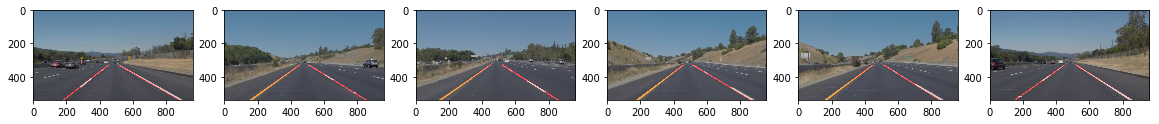

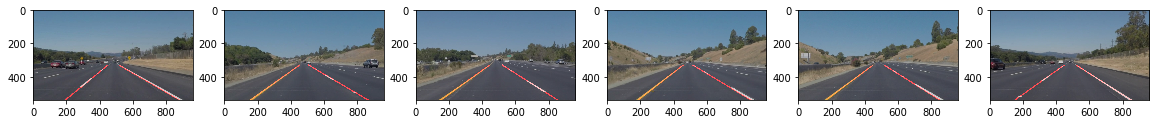

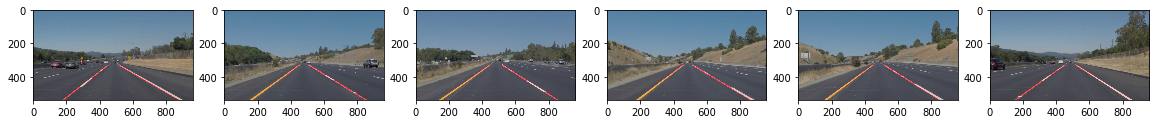

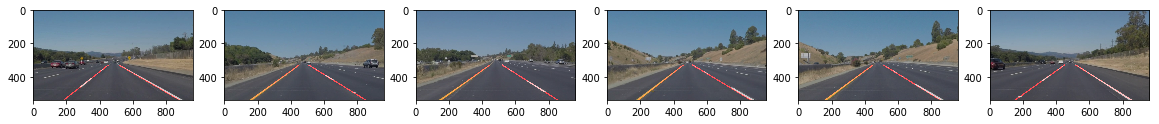

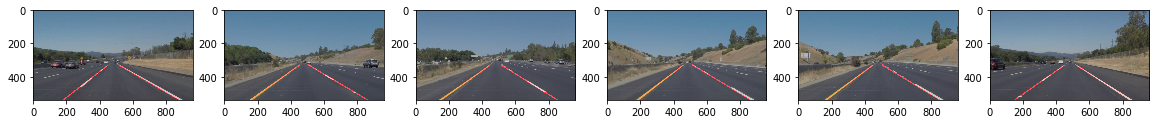

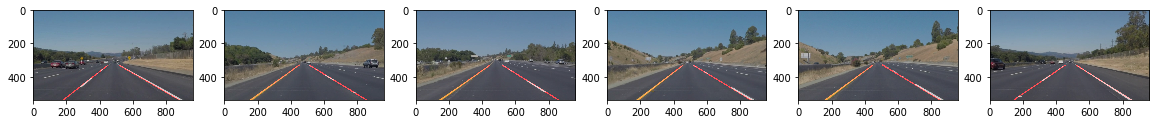

In [47]:
# main function to get the best canny
# result shows 10 degress. Modify the default as such
# started wit:
#   gaussian_kernel_size = 5 # default
#   rho = 1 # default
if Find_Best_Parameters == True:
    gray_imgs = [ grayscale(img) for img in imgs ]
    gaussian_imgs = [ gaussian_blur(gray_img, gaussian_kernel_size) for gray_img in gray_imgs ]
    canny_thresholds = [[50+(i*10), 150+(i*30)] for i in range(6)]

    for canny_threshold in canny_thresholds:
        canny_low_threshold = canny_threshold[0]
        canny_high_threshold = canny_threshold[1]

        canny_edge_images = [ canny(gaussian_img, canny_low_threshold, canny_high_threshold) for gaussian_img in gaussian_imgs ]
        masks = [ region_of_interest(canny_edge_image, vertices) for canny_edge_image in canny_edge_images ]
        houghs = [hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap) for mask in masks]
        weighted_imgs = [weighted_img(hough, initial_img) for (initial_img, hough) in zip(imgs, houghs)]
        images_per_line = len(weighted_imgs)
        fig=plt.figure()
        for i, img in enumerate(weighted_imgs):
            ax = plt.subplot(1, images_per_line, i+1)
            plt.title = 'Hello'
            plt.imshow(img, cmap='gray')
        print ("gaussian_kernel_size: ", gaussian_kernel_size, " canny_low_threshold: ", canny_low_threshold, " canny_high_threshold: ", canny_high_threshold, " rho: ", rho, " theta: ", theta *180/np.pi)


In [48]:
#Conclusion: best canny is the first.
if Find_Best_Parameters == True:
    canny_threshold=canny_thresholds[0]
    canny_low_threshold = canny_threshold[0]
    canny_high_threshold = canny_threshold[1]
    print (canny_threshold)

[50, 150]


gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0
gaussian_kernel_size:  5  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0
gaussian_kernel_size:  7  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0
gaussian_kernel_size:  9  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0
gaussian_kernel_size:  11  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0


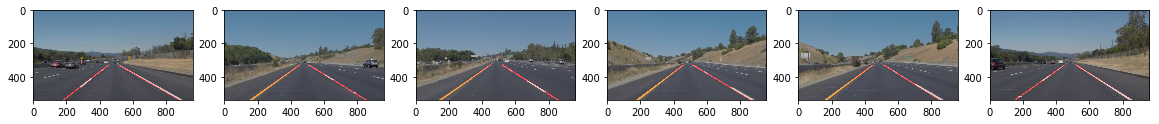

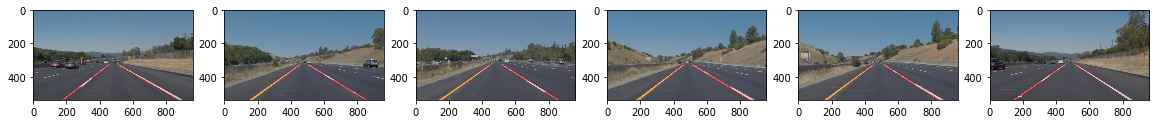

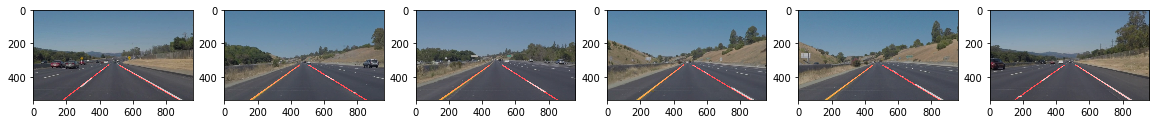

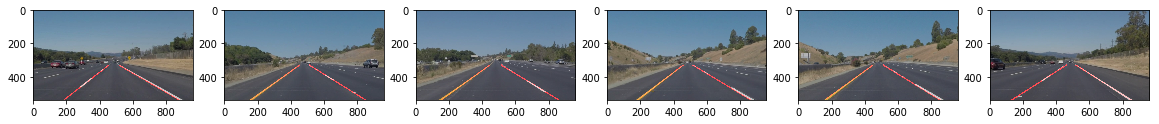

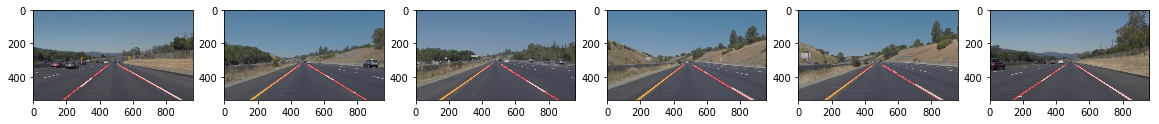

In [49]:
# main function to get the best gaussian
# result shows 10 degress. Modify the default as such
# started wit:
#   gaussian_kernel_size = 5 # default
#   rho = 1 # default
if Find_Best_Parameters == True:
    gray_imgs = [ grayscale(img) for img in imgs ]
    for gaussian_kernel_size in gaussian_kernel_sizes:
        gaussian_imgs = [ gaussian_blur(gray_img, gaussian_kernel_size) for gray_img in gray_imgs ]
        canny_low_threshold = canny_threshold[0]
        canny_high_threshold = canny_threshold[1]
        canny_edge_images = [ canny(gaussian_img, canny_low_threshold, canny_high_threshold) for gaussian_img in gaussian_imgs ]
        masks = [ region_of_interest(canny_edge_image, vertices) for canny_edge_image in canny_edge_images ]
        houghs = [hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap) for mask in masks]
        weighted_imgs = [weighted_img(hough, initial_img) for (initial_img, hough) in zip(imgs, houghs)]
        images_per_line = len(weighted_imgs)
        fig=plt.figure()
        for i, img in enumerate(weighted_imgs):
            ax = plt.subplot(1, images_per_line, i+1)
            plt.title = 'Hello'
            plt.imshow(img, cmap='gray')
        print ("gaussian_kernel_size: ", gaussian_kernel_size, " canny_low_threshold: ", canny_low_threshold, " canny_high_threshold: ", canny_high_threshold, " rho: ", rho, " theta: ", theta *180/np.pi)


In [50]:
#Conclusion: best gaussian_kernel_size is the first
if Find_Best_Parameters == True:
    gaussian_kernel_size=gaussian_kernel_sizes[0]
    print (gaussian_kernel_size)

3


gaussian_kernel_size:  3  canny_low_threshold:  50  canny_high_threshold:  150  rho:  1  theta:  1.0


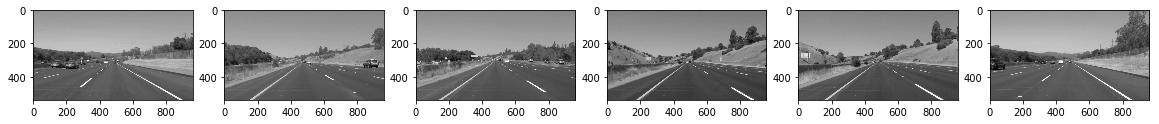

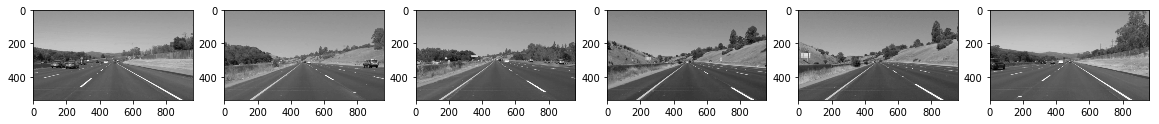

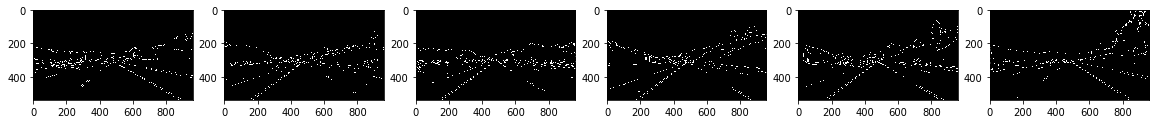

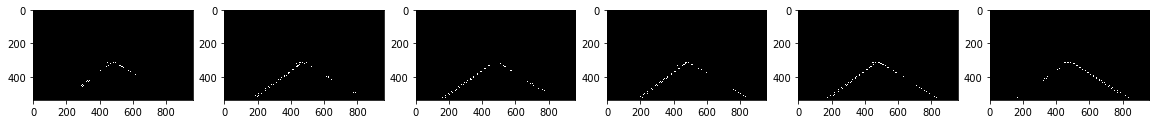

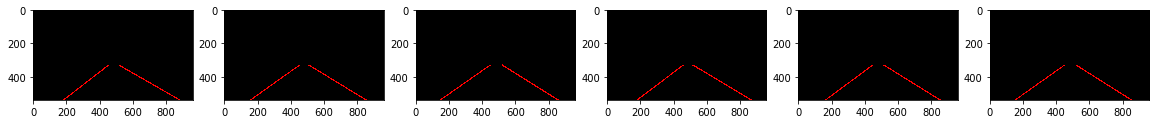

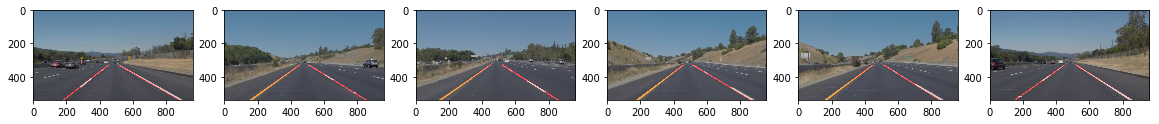

In [51]:
# main function to generate the output and intermediate images after all the tests
# Also lower the RegionUpperY

gray_imgs = [ grayscale(img) for img in imgs ]
show(gray_imgs)
gaussian_imgs = [ gaussian_blur(gray_img, gaussian_kernel_size) for gray_img in gray_imgs ]
show(gaussian_imgs)
canny_edge_images = [ canny(gaussian_img, canny_low_threshold, canny_high_threshold) for gaussian_img in gaussian_imgs ]
show(canny_edge_images)
masks = [ region_of_interest(canny_edge_image, vertices) for canny_edge_image in canny_edge_images ]
show(masks)
houghs = [hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap) for mask in masks]
show(houghs)
weighted_imgs = [weighted_img(hough, initial_img) for (initial_img, hough) in zip(imgs, houghs)]
print ("gaussian_kernel_size: ", gaussian_kernel_size, " canny_low_threshold: ", canny_low_threshold, " canny_high_threshold: ", canny_high_threshold, " rho: ", rho, " theta: ", theta *180/np.pi)
show(weighted_imgs)

In [52]:
# main loop to convert the images and save them into the output directory
output_images = weighted_imgs
for output_image, imagefilename in zip(output_images, list_im):
    outputimagefilename = testoutputdir+imagefilename
    mpimg.imsave(outputimagefilename , output_image, format="jpeg")

# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [53]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [54]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    
    gray_img = grayscale(image)
    gaussian_img = gaussian_blur(gray_img, gaussian_kernel_size)
    canny_edge_image = canny(gaussian_img, canny_low_threshold, canny_high_threshold)
    mask = region_of_interest(canny_edge_image, vertices)
    hough = hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(hough, image)
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [55]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
testvideodir="test_videos/"
testvideooutputdir="test_videos_output/"
if (os.path.exists(testvideooutputdir)):
    pass
else:
    os.mkdir(testvideooutputdir)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 36.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 16.9 s, sys: 620 ms, total: 17.5 s
Wall time: 7.59 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [57]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:14<00:00, 46.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 50.4 s, sys: 1.35 s, total: 51.7 s
Wall time: 15 s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [59]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 26.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 22.8 s, sys: 776 ms, total: 23.6 s
Wall time: 10.3 s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))